# Monte Carlo introduction to Python, NumPy and Jupyter notebooks

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mkl

from IPython.display import display, HTML
from matplotlib.animation import FuncAnimation

np.random.seed(1234)
mkl.set_num_threads(2)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams["figure.figsize"] = [16, 9]

## Estimating π with Monte Carlo

Implement ```sample_points``` function. This function should sample ```count``` points from a $d$-dimensional cube  $[-1, 1]^d$ and return tuple with two NumPy arrays:
- the first tuple element should be an array of points that fall inside the $d$ dimensional ball centered at origin and with unit radius,
- the second element should be an array with points that fall outside that ball.

Point coordinates should be stored row-wise.

In [7]:
def sample_points(count, d):
    # Generate a random sample with uniform distribution
    points = np.random.uniform(-1,1,(count,d))
    # Sum of squares of coordinates of given poitns
    radii = np.sum(points * points,axis=1)
    # We take here R = 1 => R^2 = 1
    inner = points[radii <= 1]
    outer = points[radii > 1]
    return inner, outer

Implement ```approx_pi_mc``` function, which uses a draw from ```sample_points``` to estimate the vaue of $\pi$. Arguments are:
- ```sample``` - a tuple returned by ```sample_pints``` with d=2. 

Note that you can estimate $\pi$ by approximating the surface area of a $2$-dimensional ball (disc) with a given radius. This is nothing else than approximating the integral of an indicator function over the surface of that ball. Plain Monte Carlo is good at approximating integrals when dimensionality is not overly large.

In [9]:
def approx_pi_mc(sample):
    inner, outer = sample
    # The approximation is the amount of points inside the circle to all of the points in the square,
    # Surface of square is of course 4 
    pi_approx = len(inner) / (len(inner) + len(outer)) * 4
    return pi_approx

### Visualization

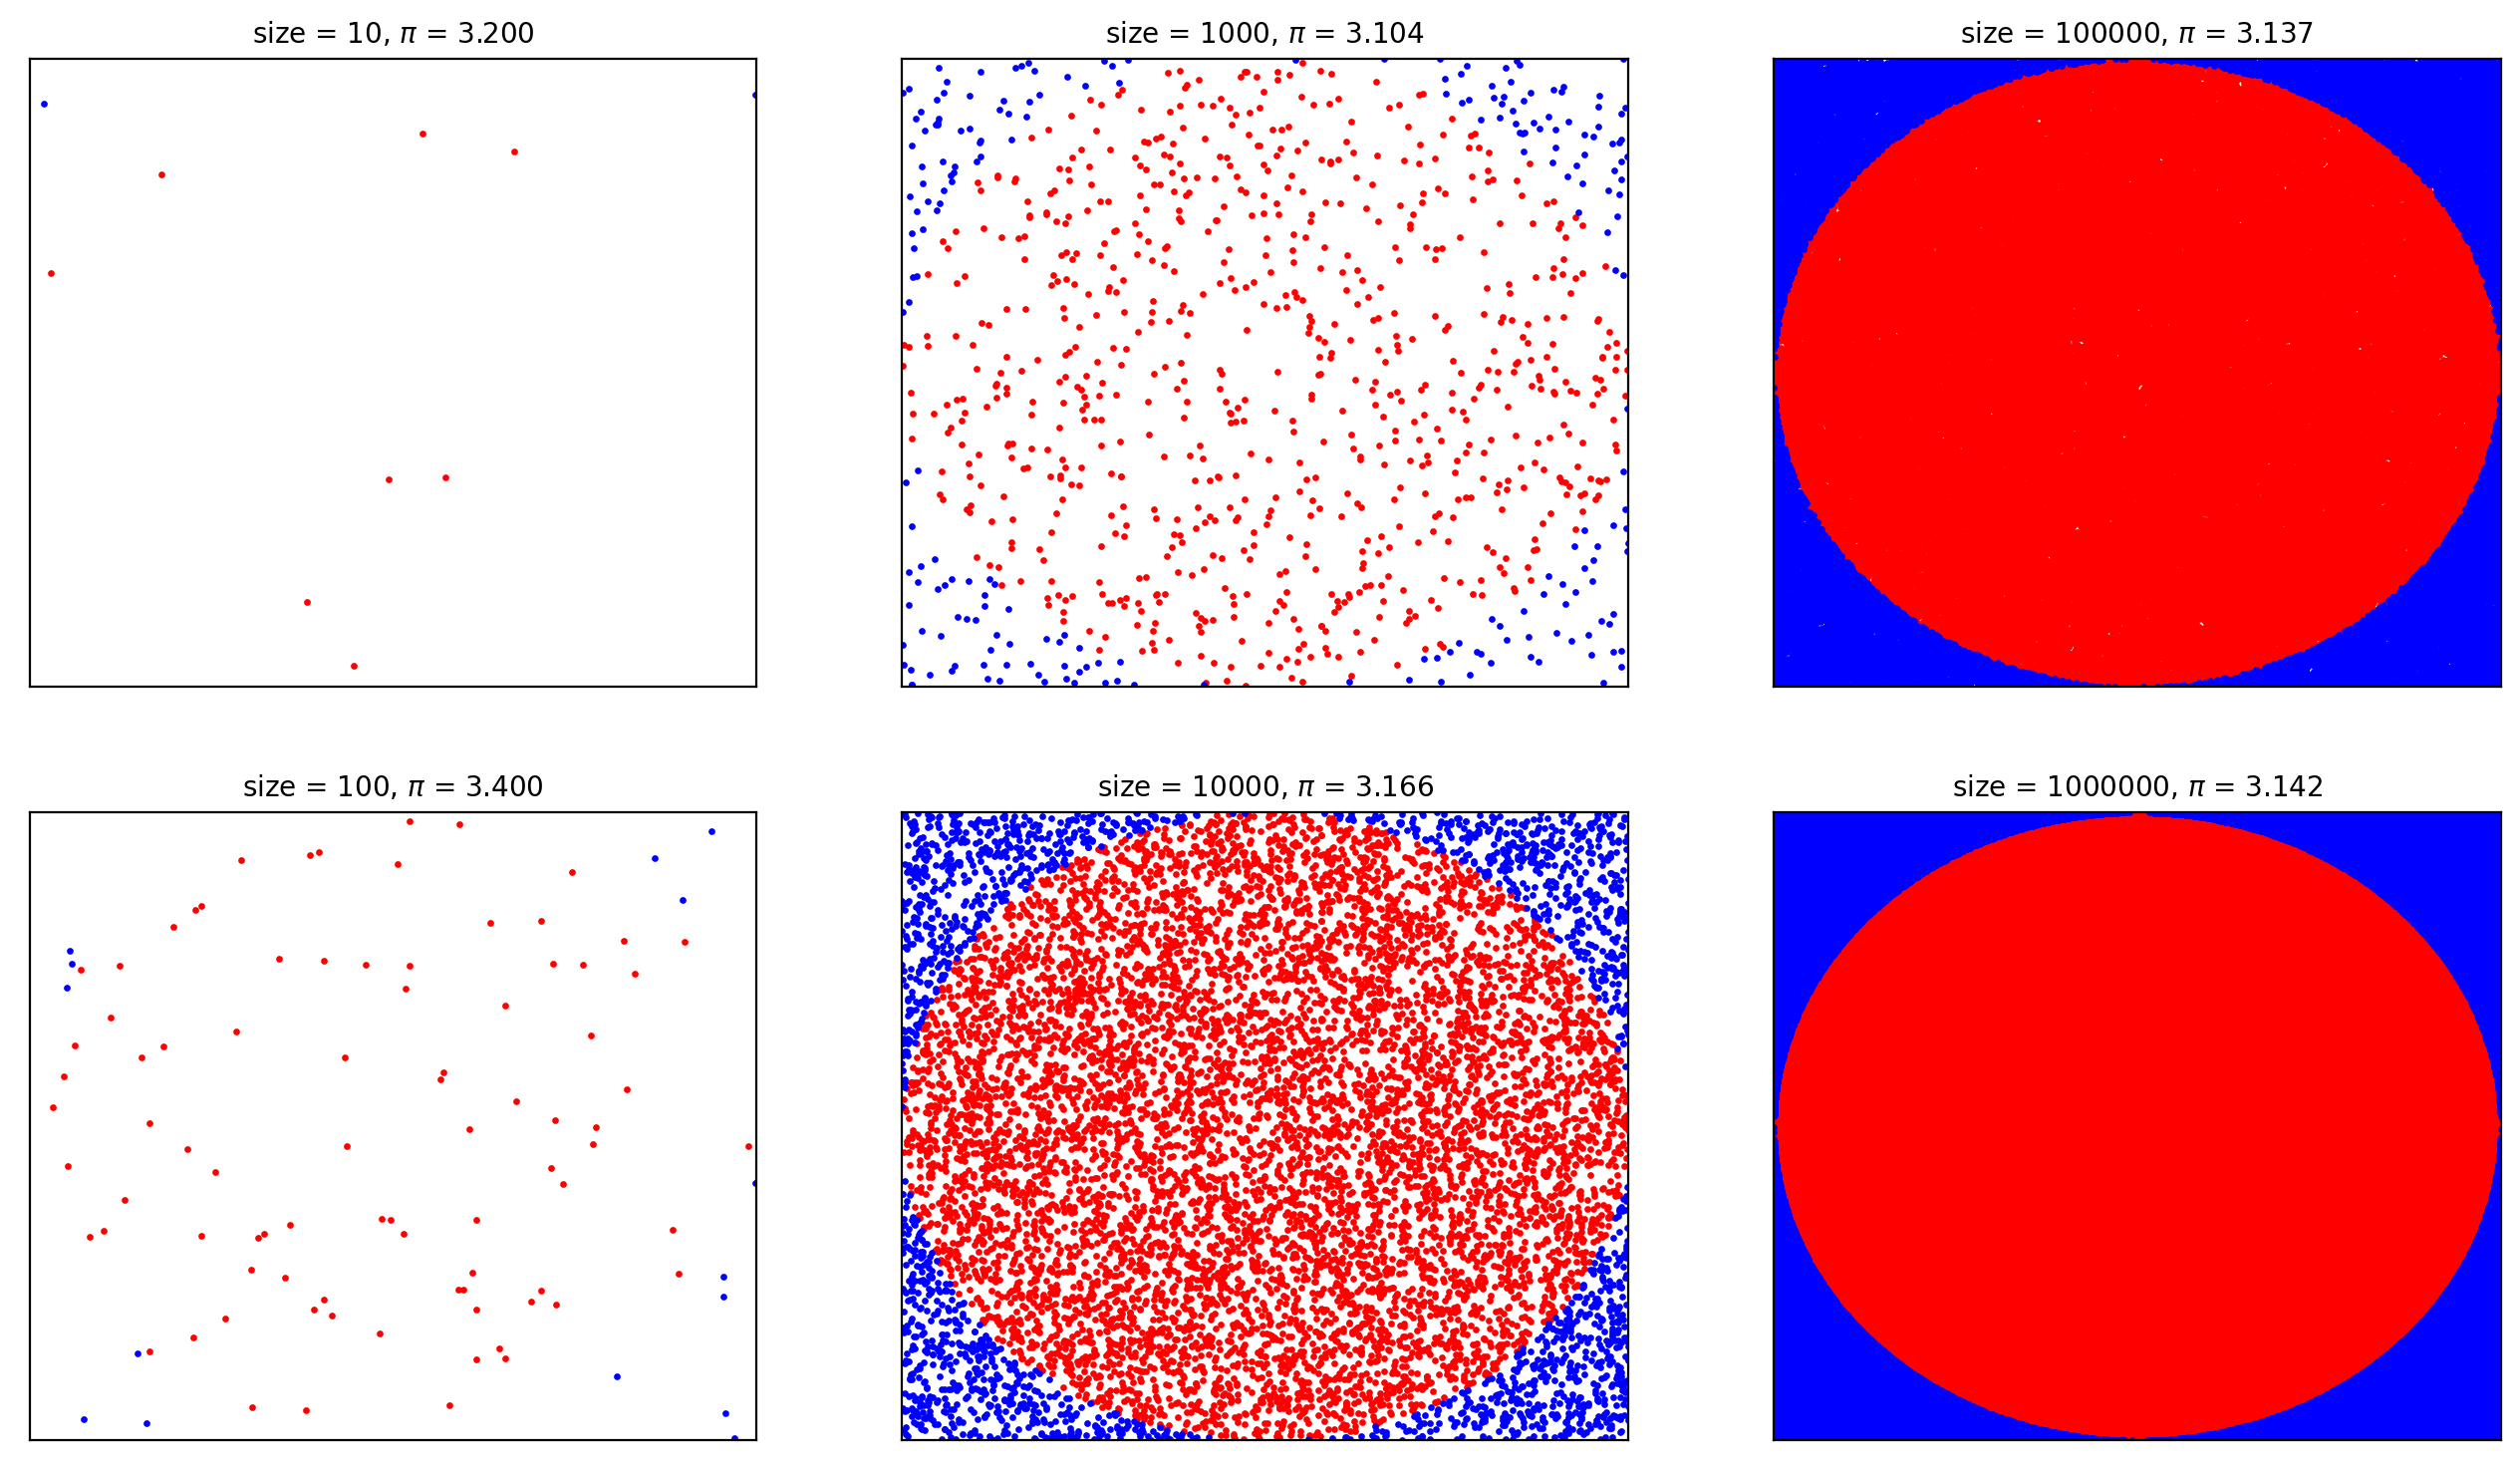

In [11]:
counts = [10 ** i for i in range(1, 7)]

figure, axis = plt.subplots(2, 3, figsize=(16, 9))

def update(idx):
    row, col = idx % 2, idx //2
    n = counts[idx]
    sample = sample_points(n, 2)
    inner, outer = sample

    pi = approx_pi_mc(sample)

    axis[row][col].set_title(f'size = {n}, $\pi$ = {pi:.3f}', fontsize = 10)
    axis[row][col].scatter(inner[:, 0], inner[:, 1], c='r', s=2)
    axis[row][col].scatter(outer[:, 0], outer[:, 1], c='b', s=2)
    axis[row][col].set_xlim((-1, 1))
    axis[row][col].set_ylim((-1, 1))
    axis[row][col].set_xticks([])
    axis[row][col].set_yticks([])

for i in range(len(counts)):
    update(i)

plt.show()

## Monte Carlo cont. - what is the ratio between volume of a $d$-dimensional (inscribed) ball and volume of a $d$-dimensional hypercube?

Use ```sample_pints``` to estimate the ratio between volume of a $d$-dimensional ball and volume of a $d$-dimensional inscribing hypercube. Use ```ratio_sample_size``` points to estimate that ratio.

In [17]:
ratio_sample_size = 10000

def volume_ratio(d):
    inner, outer = sample_points(ratio_sample_size,d)
    return len(inner) / ratio_sample_size # The same as before, but in d dimensions

Lets see how that ratio changes with the number of dimensions.

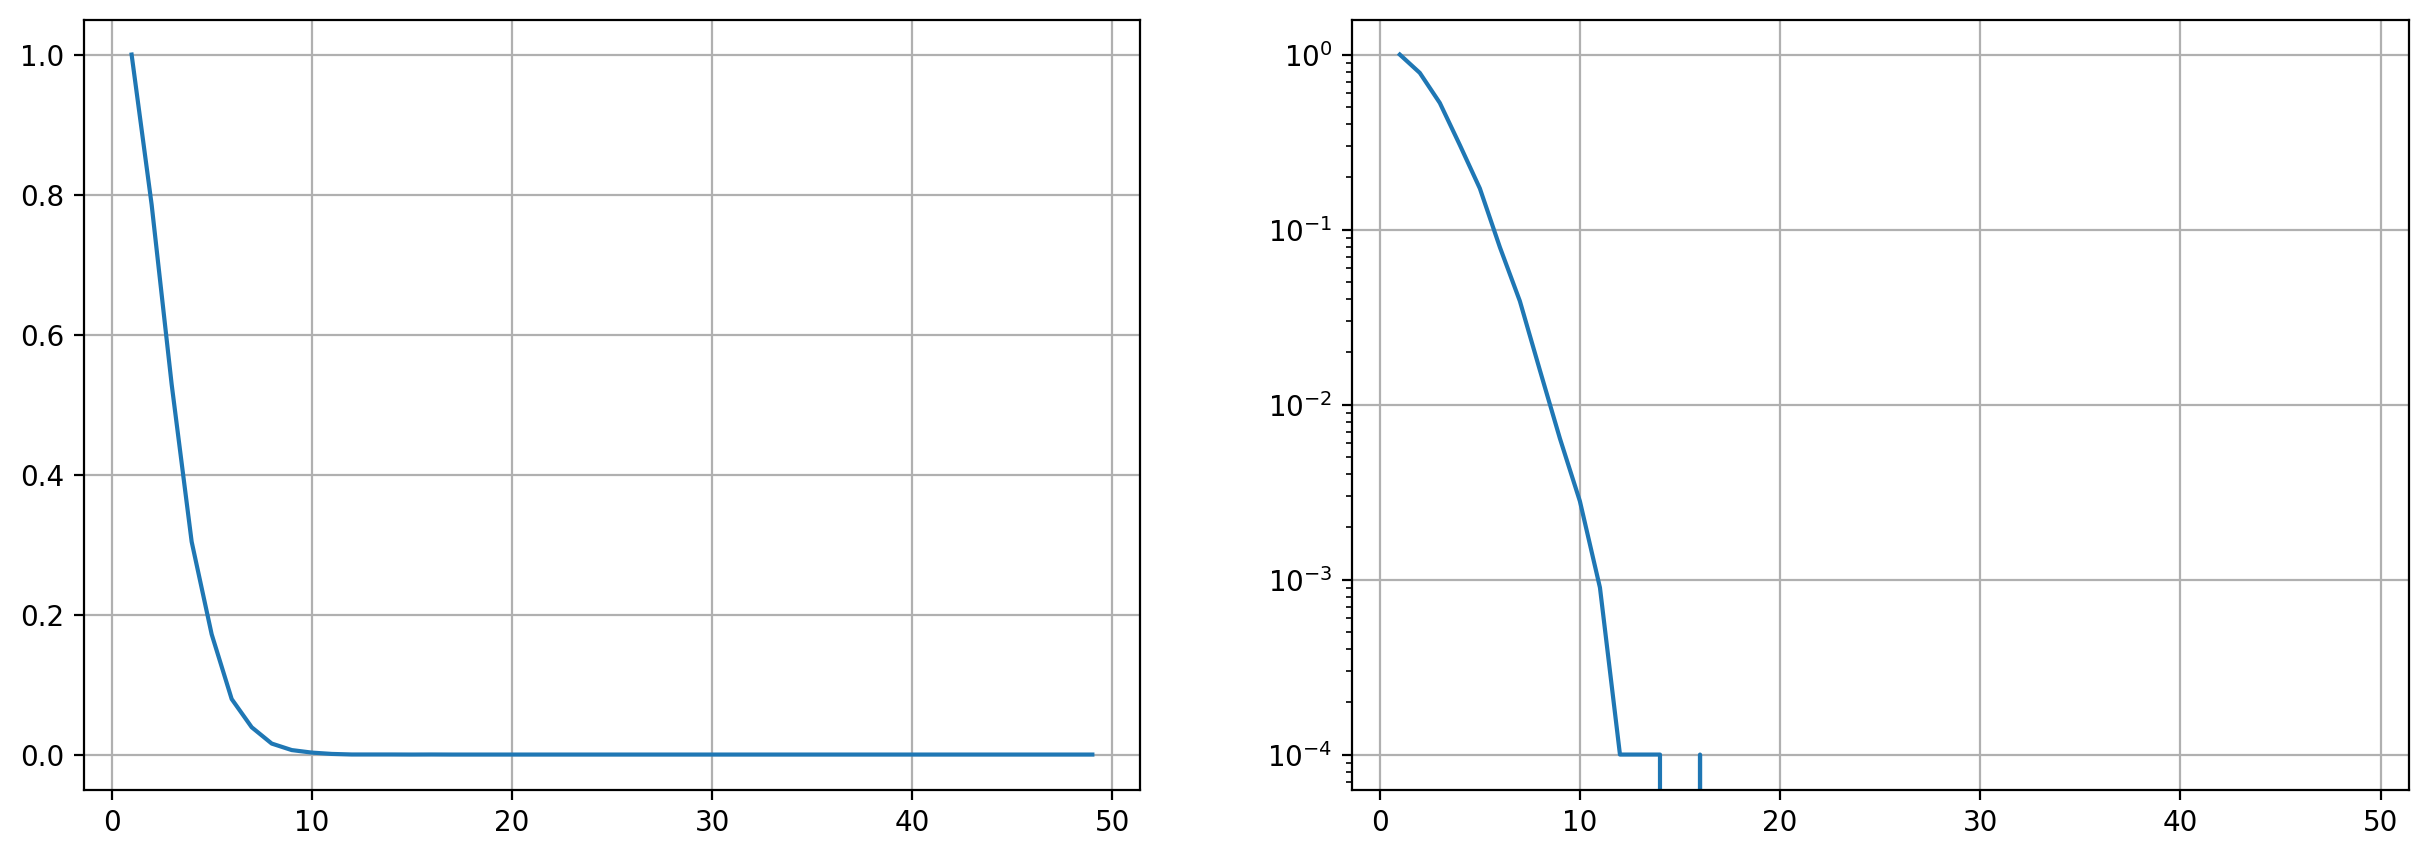

In [18]:
dims = np.arange(1, 50, 1)
ratios = np.vectorize(volume_ratio)(dims)

figure, axis = plt.subplots(1, 2, figsize=(15, 5))
axis[0].grid()
axis[0].plot(dims, ratios)
axis[1].grid()
axis[1].semilogy()
axis[1].plot(dims, ratios);

## Monte Carlo cont. <br> Samplig points uniformly from a $d$-dimensional ball is trivial, right? Not.

Rejection sampling won't work above approx. 10 dimensions - most samples will fall outside the ball and be rejected. But wait! How about we:
- first sample the radius (uniformly),
- then sample the direction (i.e. a unit vector from $\mathbb{R}^d$),
- then generate the point by combining radius and direction?.

Implement ```sample_directions``` function, which returns points sampled randomly from the surface of a $d$-dimensional ball centered at origin and with unit radius. ```sample_directions``` should return an NumPy array, where each row is a sampled point (coordinates).

In [37]:
def sample_directions(count, d):
    #
    # Normal distribution, because it has a circular shape, so it will uniformly (with respect to angle)
    # generate unit vectors 
    #
    points = np.random.normal(size = (count,d))
    #
    # Uniform distribution generates an X-shaped areas of higher density, because we normalize points from corners.
    # If we were to radially count the amount of points using a sweepline, we would find that on average the 
    # highest count of points is on diagonals of the given interval. This applies to any square-shaped or in general
    # hypercube shaped interval, but in the latter case we would have the highest count on diagonal hyperplanes 
    # (whatever that means to our 3-d limited intuition)
    #
    # points = np.random.uniform(-1,1,(count,d))
    #
    # Normalization using broadcasting because the latter here is the array of norms for each point
    return points / np.linalg.norm(points,axis=1,keepdims=True)

Lets generate some points.

In [38]:
sample_size = 5000

# First we sample directions:
w = sample_directions(sample_size, 2)

# Then we sample radii:
r = np.random.uniform(low = 0.0, high = 1.0, size = sample_size)

# And now we can generate points:
ball_samples = w * r.reshape((-1, 1))

And plot the distribution.

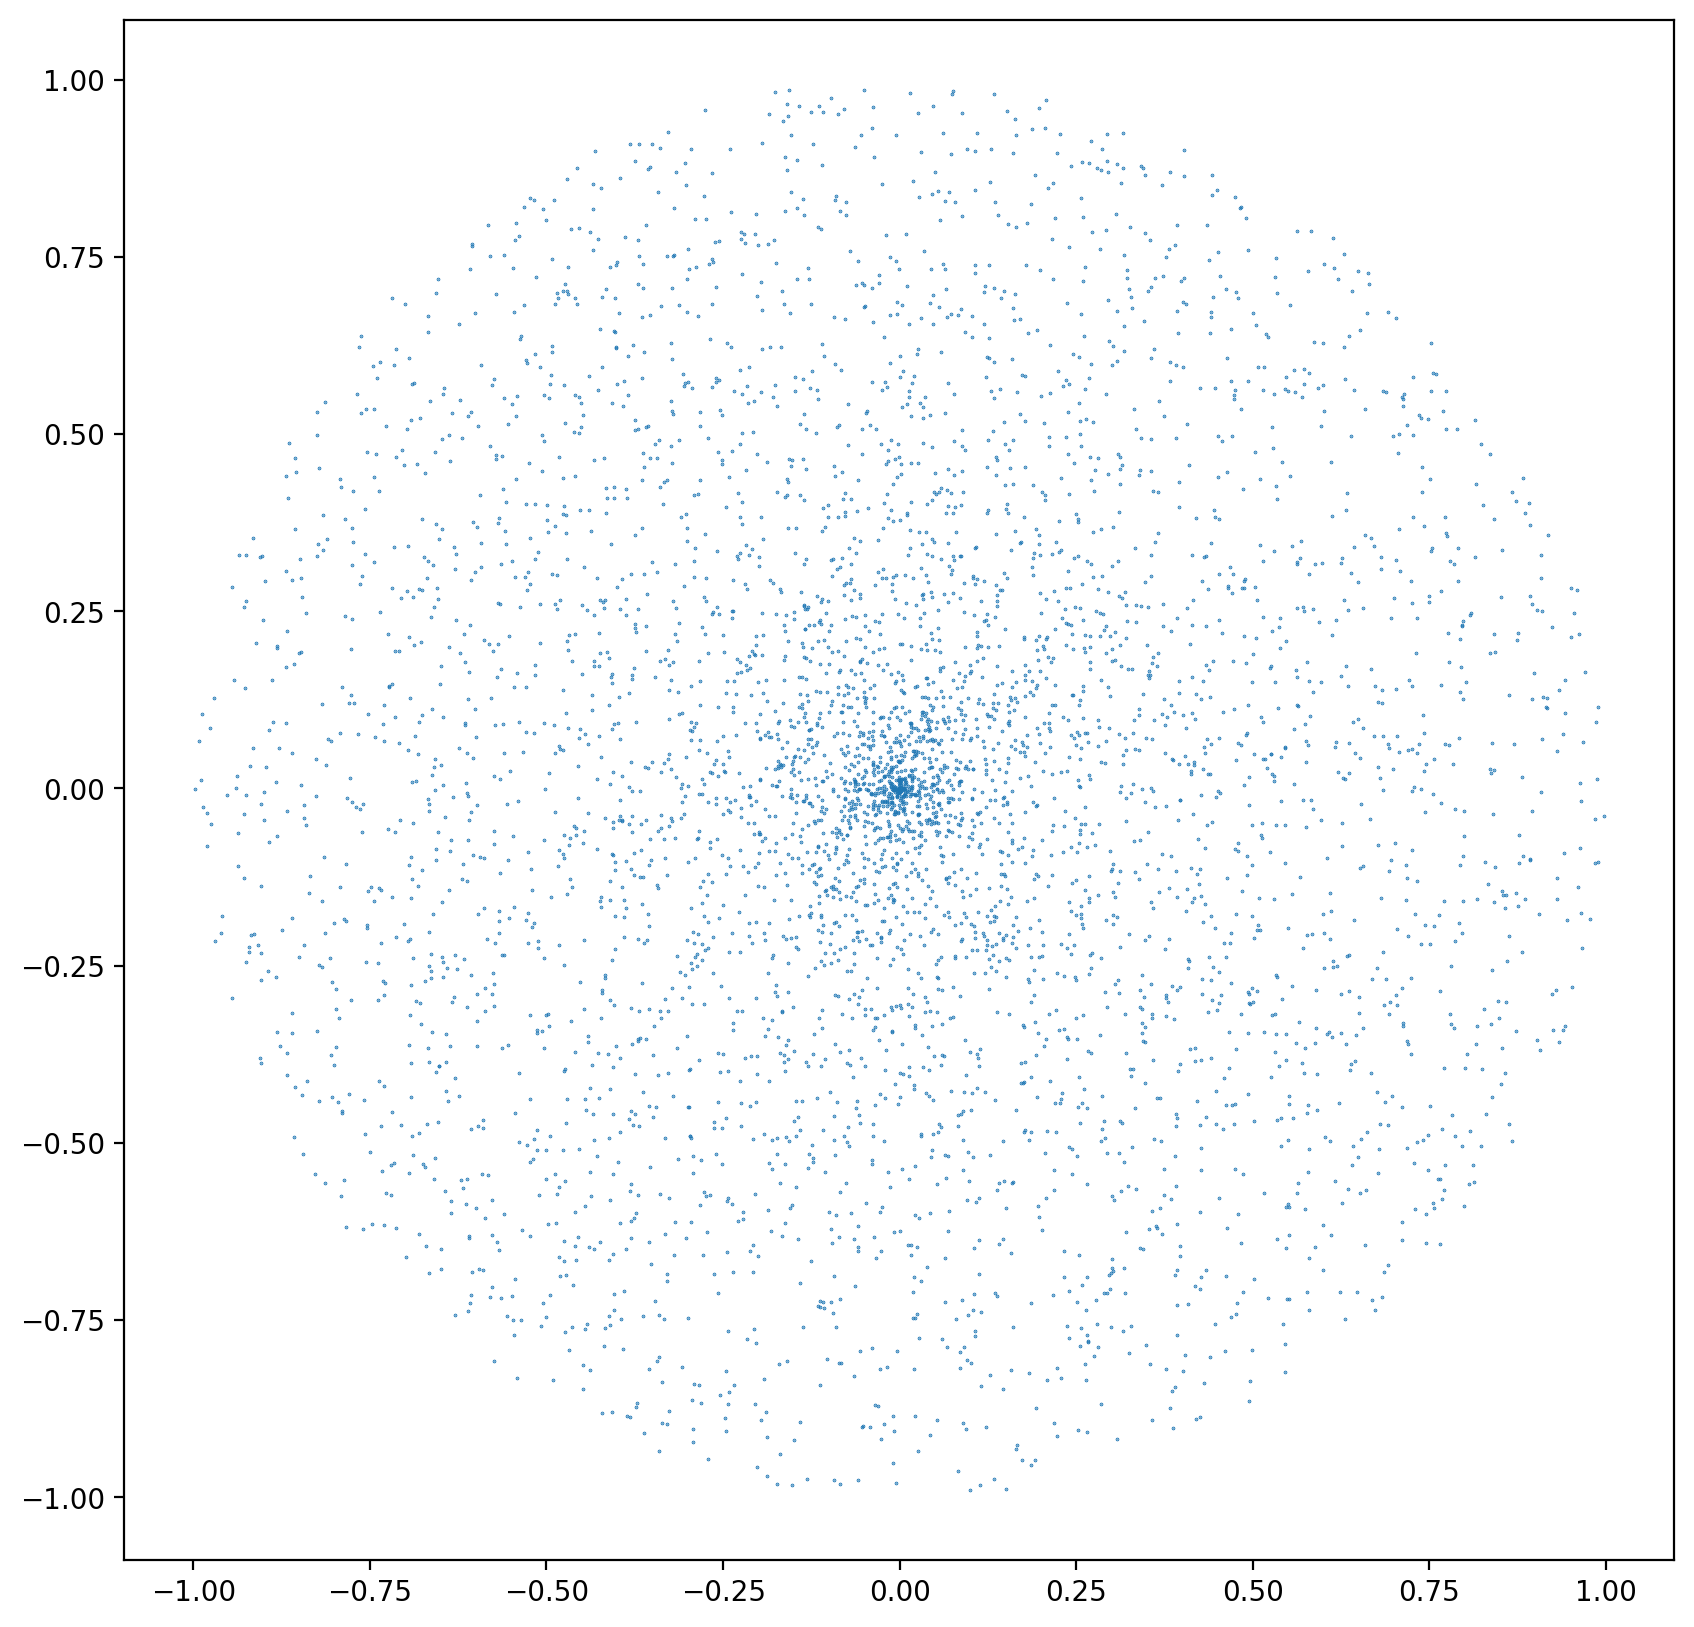

In [39]:
plt.subplots(figsize=(10, 10))
plt.scatter(ball_samples[:, 0], ball_samples[:, 1], s=0.1)
plt.plot();

**Is this a uniform distribution?**

Sampling in many dimensions is not always easy - in fact it's often very hard. Latter in the course we will talk about Markov Chain Monte Carlo (MCMC) methods, which are better at sampling from complicated high-dimensional distributions.

## An exercise - make the coin fair.

Lets say we have an unfair coin, which falls heads 90% of times and tails 10% of times.

In [40]:
def unfair_coin():
    return np.random.choice([0, 1], p=[0.1, 0.9])

Your task is to implement ```make_coin_fair``` function which returns unbiased and uncorrelated samples from $\{0, 1\}$, each with probability $0.5$.

**Note:** the only source of randomness you are allowed to use is ```unfair_coin``` function. Whatever you implement, you should be abl to justify that the returned samples are fair and uncorrelated. 

In [123]:
def make_coin_fair():
    #
    # We wait for the coin to become fair. This is because we can force an even probility:
    # previous / current |     Heads (1)     |     Tails (0)     |
    # ____________________________________________________________
    #      Heads (1)     |       0.81        |       0.09        |
    #      Tails (0)     |       0.09        |       0.01        |
    # ____________________________________________________________
    # So we can arbitrarily choose Tails + Heads (01) to mean heads for us
    # and Heads + Tails (10) to be tails. We toss the coin until we obtain one of the
    # aforementioned configurations.
    # P(01) = P(0) * P(1) = 0.09
    # P(10) = P(1) * P(0) = 0.09
    # Since P(01) = P(10), these two sequences occur with equal probability => Probability of getting 
    # either one is 0.5
    #
    LOOP_SWITCH = False
    if LOOP_SWITCH:
        while True:
            # Function has a chance of running forever
            previous = unfair_coin()
            current = unfair_coin()
            if previous > current:
                return 0
            elif previous < current:
                return 1
    else:
        # With arrays   
        amount = 30
        samples = np.array([(unfair_coin(), unfair_coin()) for _ in range(amount)])
        
        # Find the first occurrence of (0,1) and (1,0)
        heads_first = np.where((samples[:, 0] == 0) & (samples[:, 1] == 1))[0]
        tails_first = np.where((samples[:, 0] == 1) & (samples[:, 1] == 0))[0]

        # Ensure we found at least one valid pair
        if len(heads_first) > 0 and len(tails_first) > 0:
            return int(heads_first[0] > tails_first[0])
        elif len(heads_first) > 0:
            return 1
        elif len(heads_first) > 1:
            return 0
        # Or returning none of the pairs are found, which has a probability of (0.82)^amount of it happening
        return 0 # So that the one below does not break, but we will break the 'fairness' of the coin
        

### Let's see what you did there

In [124]:
test_size = 5000

samples = np.array([make_coin_fair() for i in range(test_size)])
heads = np.sum(samples == 1) / samples.shape[0]
tails = np.sum(samples == 0) / samples.shape[0]

acorr = np.correlate(samples, samples, mode='valid')[0] / test_size

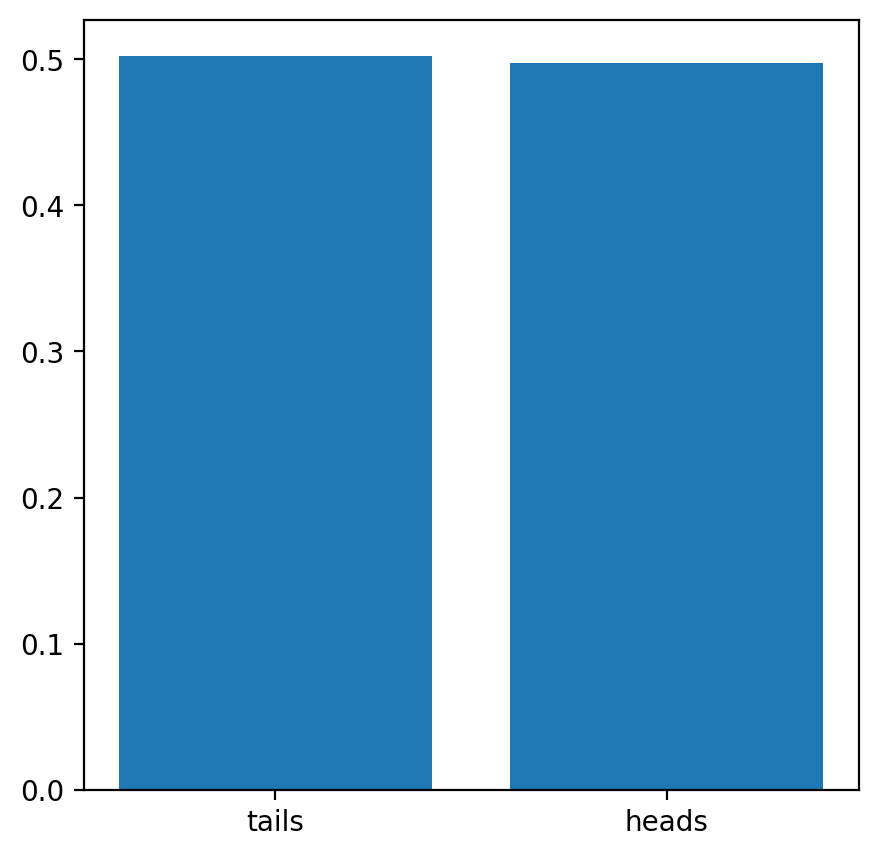

In [125]:
figure, axis = plt.subplots(figsize=(5, 5))
axis.bar([0, 1], [tails, heads])
axis.set_xticks([0, 1])
axis.set_xticklabels(['tails', 'heads'])

display(HTML(f'<h4>(Convolutional) Auto correlation: {acorr}</h4>'))